# From Google Earth to a geological model

## Import

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import mplstereonet
from importlib import reload

import sys
import os
sys.path.append(r"..")  # append local path to access rgeomod module
import rgeomod

## Import, process and visualize Google Earth data

### Load .kml files

In [4]:
folder_path = "../data/FW1/"

In [5]:
ks, ks_names, ks_bool = rgeomod.read_kml_files(folder_path)

read kml
1 point sets added
01_Unit_1_interf.kml


read kml
3 point sets added
02_Unit_2_interf.kml


read kml
4 point sets added
03_Unit_3_interf.kml
Removed point set #1


read kml
3 point sets added
04_Unit_4_interf.kml


read kml
16 point sets added
dips.kml




*ks* contains the KmlPoints objects, containing the point data from the respective .kml files in the given directory:

In [6]:
ks

*ks_names* contains the filenames:

In [7]:
ks_names

['01_Unit_1_interf',
 '02_Unit_2_interf',
 '03_Unit_3_interf',
 '04_Unit_4_interf',
 'dips']

*ks_bool* is a boolean array specifying which object contains dip values:

In [8]:
ks_bool

array([False, False, False, False,  True], dtype=bool)

### Load DTM to obtain elevation data and fit planes

In [9]:
geotiff_filepath = "../data/dome_sub_sub_utm.tif"

In [10]:
rgeomod.fetch_z_from_dtm(ks, geotiff_filepath)

### Convert to data frames

In [11]:
interfaces, foliations = rgeomod.convert_to_df(ks, ks_names, ks_bool)

In [12]:
interfaces.tail()

,X,Y,Z,formation,series
59,617135.925653,2.474104e+06,385.0,04_Unit_4_interf,Default series
60,616633.866222,2.474098e+06,391.0,04_Unit_4_interf,Default series
61,616040.905232,2.474211e+06,500.0,04_Unit_4_interf,Default series
62,615735.772262,2.473834e+06,362.0,04_Unit_4_interf,Default series
63,615010.028566,2.473774e+06,398.0,04_Unit_4_interf,Default series


In [13]:
foliations.tail()

,X,Y,Z,dip,azimuth,polarity,formation,series
11,617537.992479,2.479068e+06,461.875000,34.497184,349.883630,1,01_Unit_1_interf,Default series
12,619683.550025,2.478926e+06,469.375000,65.801180,43.522475,1,01_Unit_1_interf,Default series
13,620183.977449,2.478372e+06,467.900000,40.755717,53.592270,1,01_Unit_1_interf,Default series
14,617105.587985,2.475285e+06,602.000000,32.487338,148.738537,1,01_Unit_1_interf,Default series
15,618645.592616,2.476287e+06,575.714286,19.157720,117.215020,1,01_Unit_1_interf,Default series


### Visualize points in 3D

Text(0.5,0.98,'GoogleEarth picks')

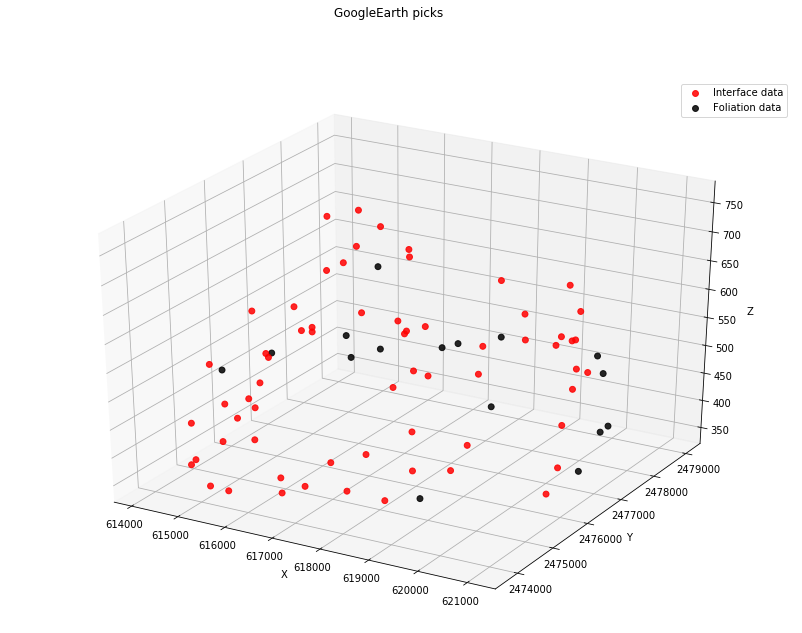

In [14]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(interfaces["X"], interfaces["Y"], interfaces["Z"], color="red", alpha=0.85, s=35, label="Interface data")
ax.scatter(foliations["X"], foliations["Y"], foliations["Z"], color="black", alpha=0.85, s=35, label="Foliation data")

ax.legend()
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
fig.suptitle("GoogleEarth picks")

# Visualize dip and azimuth 

Plot histograms of the extracted dip and dip direction data:

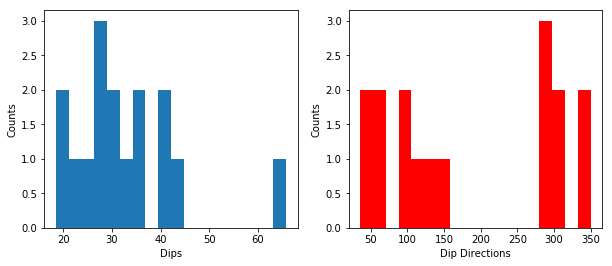

In [15]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(foliations["dip"], 18)
ax1.set_xlabel("Dips")
ax1.set_ylabel("Counts")

ax2.hist(foliations["azimuth"], 18, color='r');
ax2.set_xlabel("Dip Directions")
ax2.set_ylabel("Counts");

### Stereonet Plots

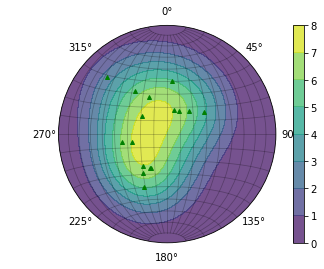

In [16]:
fig, ax = mplstereonet.subplots()
cax = ax.density_contourf(foliations["azimuth"], foliations["dip"], measurement='poles', cmap='viridis', alpha=0.75)
fig.colorbar(cax)
ax.pole(foliations["azimuth"], foliations["dip"], 'g^', markersize=4)
ax.grid(True, color="black", alpha=0.25)

plt.show()

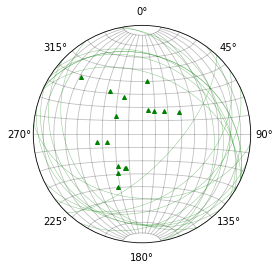

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='stereonet')
ax.pole(foliations["azimuth"], foliations["dip"], 'g^', markersize=4)
ax.plane(foliations["azimuth"], foliations["dip"], 'g-', linewidth=0.5, alpha=0.45)
ax.grid(True, color="black", alpha=0.25)

## Save to .csv files

In [18]:
interfaces.to_csv("../data/gempy_interfaces.csv", index=False)
foliations.to_csv("../data/gempy_foliations.csv", index=False)

# GemPy

In [19]:
# These two lines are necessary only if gempy is not installed
sys.path.append("../../gempy/")
sys.path.append("../gempy/")

# Importing gempy
import gempy as gp


../../gempy\gempy\UncertaintyAnalysisPYMC2.py:8: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")
../../gempy\gempy\UncertaintyAnalysisPYMC2.py:15: UserWarning: tqdm package not installed. No support for dynamic progress bars.
  warnings.warn("tqdm package not installed. No support for dynamic progress bars.")


In [20]:
geo_data=gp.create_data(extent=[612000, 622000, 2472000, 2480000, -1000, 1000], resolution=[50, 50, 50], 
                        path_f = "../data/gempy_foliations.csv",
                        path_i = "../data/gempy_interfaces.csv")

../../gempy\gempy\DataManagement.py:427: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.interfaces["series"] = [(i == _series).sum().argmax() for i in self.interfaces["formation"]]
../../gempy\gempy\DataManagement.py:430: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.foliations["series"] = [(i == _series).sum().argmax() for i in self.foliations["formation"]]


../../gempy\gempy\DataManagement.py:427: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.interfaces["series"] = [(i == _series).sum().argmax() for i in self.interfaces["formation"]]
../../gempy\gempy\DataManagement.py:430: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.foliations["series"] = [(i == _series).sum().argmax() for i in self.foliations["formation"]]


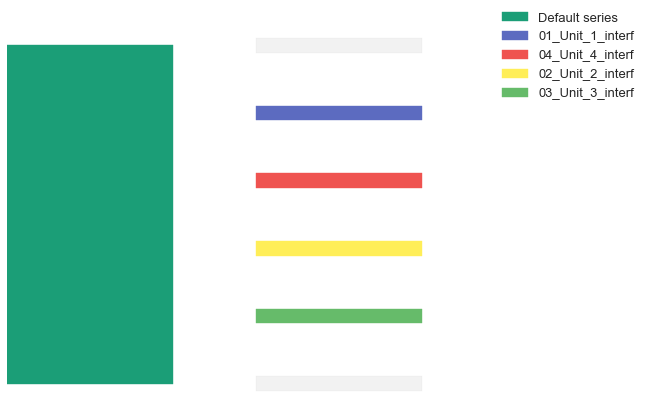

In [21]:
gp.set_series(geo_data, {"Default series": tuple(np.array(ks_names)[np.logical_not(ks_bool)])},
             order_formations = np.array(ks_names)[np.logical_not(ks_bool)])

## Data visualization

### 2D

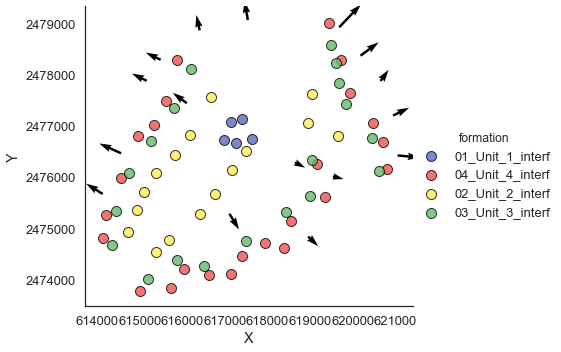

In [26]:
gp.plot_data(geo_data, direction="z")

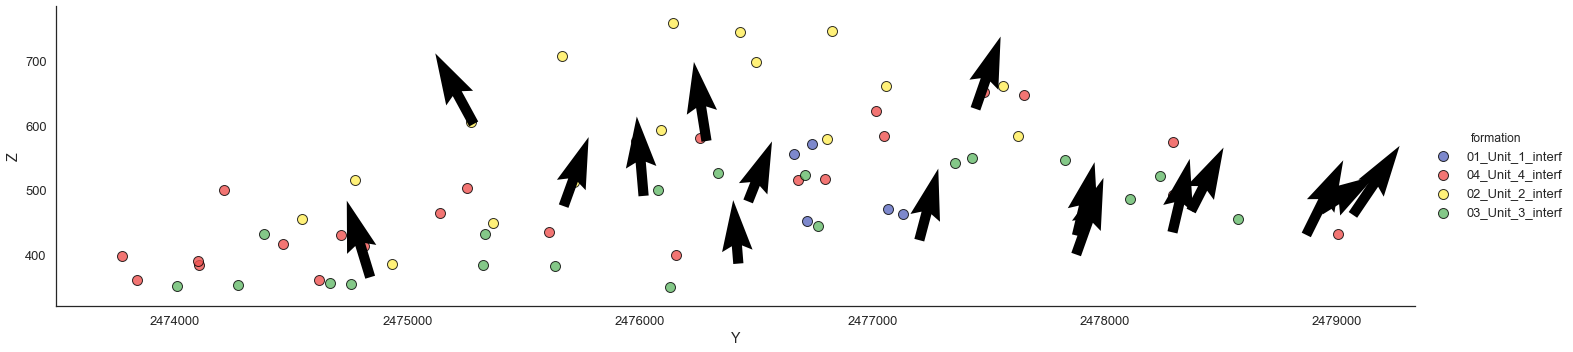

In [27]:
gp.plot_data(geo_data, direction="x")

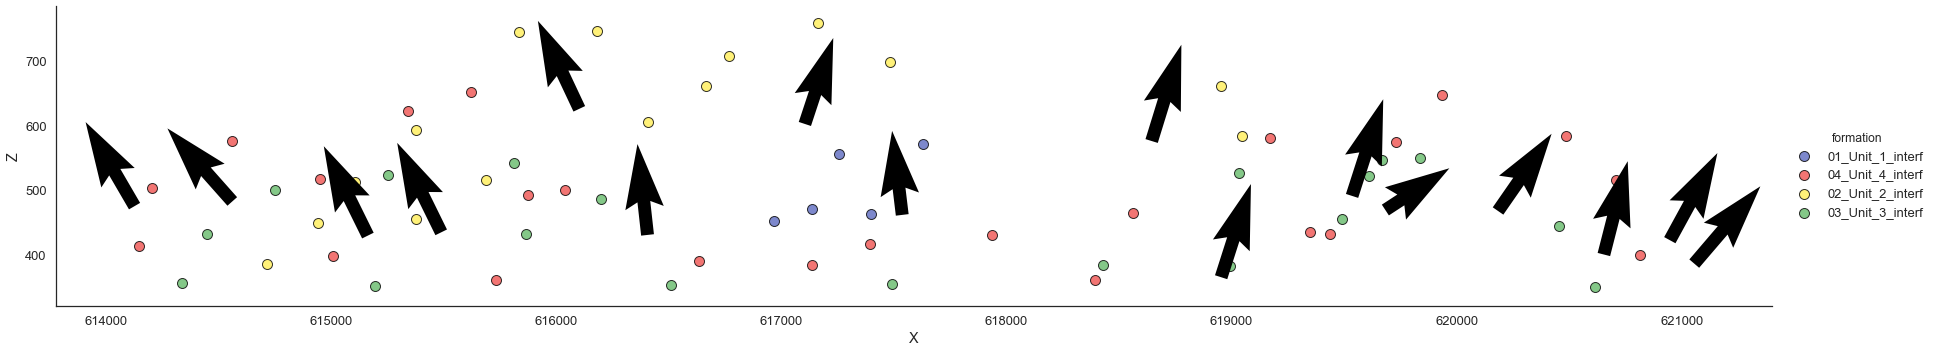

In [28]:
gp.plot_data(geo_data, direction="y")

### 3D (requires VTK)

In [25]:
gp.plot_data_3D(geo_data)

## Computing the 3D model

Instantiate interpolator

In [29]:
interp_data = gp.InterpolatorInput(geo_data, dtype="float64")

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64


Compute

In [30]:
lith_block, fault_block = gp.compute_model(interp_data)

## Model visualization

### 2D Sections

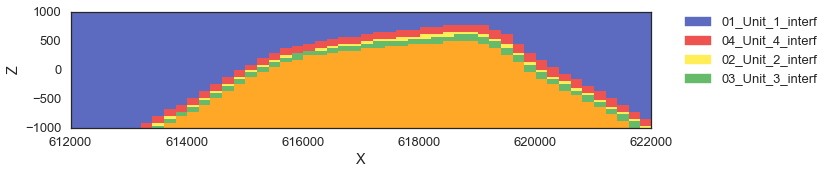

In [31]:
gp.plot_section(geo_data, lith_block[0], 40, direction='y')

### 3D Surfaces (requires VTK)

In [43]:
v_l, s_l = gp.get_surfaces(interp_data, potential_lith=lith_block[1])
gp.plot_surfaces_3D(geo_data, v_l, s_l)

### Pseudo-3D point clouds

# Map

In [33]:
import gdal
import skimage

In [34]:
xs = np.linspace(geo_data.extent[0], geo_data.extent[1], geo_data.resolution[0])
ys = np.linspace(geo_data.extent[2], geo_data.extent[3], geo_data.resolution[1])
zs = np.linspace(geo_data.extent[4], geo_data.extent[5], geo_data.resolution[2])

X,Y = np.meshgrid(xs, ys)

In [36]:
lb = lith_block[0].reshape(geo_data.resolution)

In [37]:
raster = gdal.Open(geotiff_filepath)
dtm = raster.ReadAsArray()

In [38]:
dtm_resized = skimage.transform.resize(dtm, (50,50), preserve_range=True)

C:\ProgramData\Anaconda3\envs\googlepicks\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [39]:
def htvi(dtm, zs):
    dz = (zs[-1] - zs[0]) / len(zs)
    dtm_v = (dtm - zs[0]) / dz
    return dtm_v.astype(int)

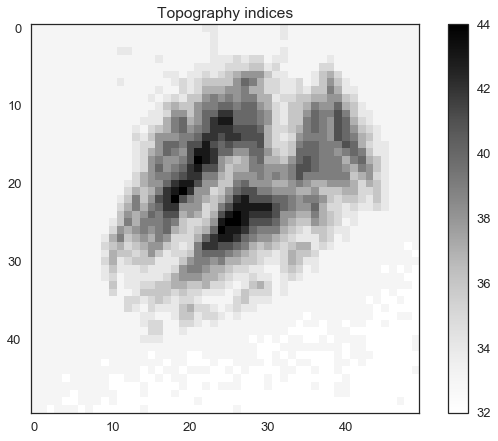

In [40]:
vdtm = plt.imshow(htvi(dtm_resized, zs))
plt.title("Topography indices")
plt.colorbar(vdtm)

In [41]:
indices = htvi(dtm_resized, zs)

geomap = np.zeros((50, 50))
for x in range(50):
    for y in range(50):
        geomap[x,y] = lb[x,y,indices[x,y]]

Text(0.5,1,'Geological map')

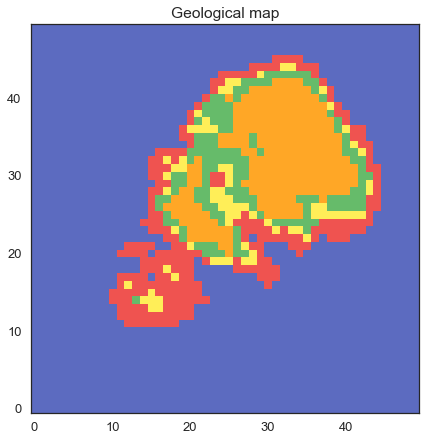

In [43]:
plt.imshow(geomap.T, origin="lower", cmap=gp.colors.cmap, norm=gp.colors.norm)
plt.title("Geological map")

In [44]:
from copy import copy

In [45]:
geoblock = copy(lb)
for x in range(50):
    for y in range(50):
        z = indices[x,y]
        geoblock[x,y,z:] = -1

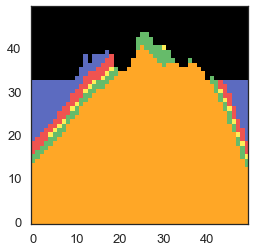

In [80]:
#plt.imshow(geoblock[25,:,:].T, origin="lower", cmap=palette)
geoblock_m = np.ma.masked_where(geoblock < 0, geoblock)
geoblock_m_inv = np.ma.masked_where(geoblock > 0, geoblock)
plt.imshow(geoblock_m_inv[25,:,:].T, origin="lower", cmap="gray")
plt.imshow(geoblock_m[25,:,:].T, origin="lower", cmap=gp.colors.cmap, norm=gp.colors.norm)

(-1000, 1000)

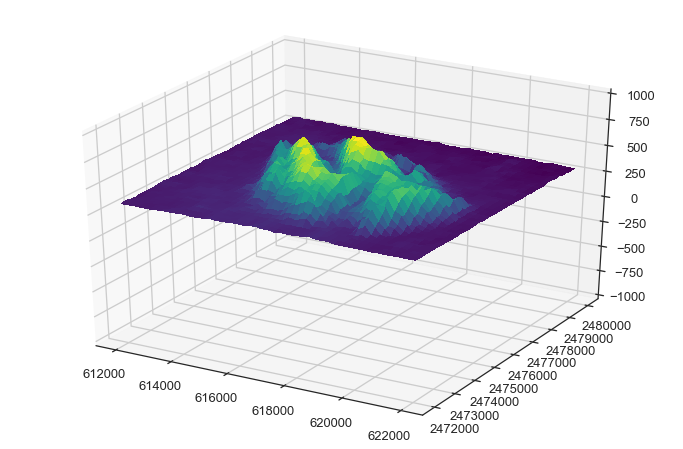

In [48]:
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, dtm_resized, cmap="viridis",
                       linewidth=0, antialiased=False)

ax.set_zlim(-1000,1000)